## Wealthy zipcodes have higher satisfaction scores than poorer zipcodes

In [27]:
from yelpapi import YelpAPI
import os
from pprint import pprint
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
import reverse_geocode
from collections import defaultdict
from uszipcode import SearchEngine
import numpy as np
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1])+'/scripts')
from csv_download import download
from Format_School_Data import create_json

This is a way of grabbing something from a function, without knowing the input variable, or if it of the correct type. This would have been one way of vetting our data, but none of it appeared to be malformed with errors that couldn't be handled with specific "except" statements, so it remained unused. It could be used at a later date if the function recieves malformed data.

In [28]:
def safe_value(fun, body, default):
    try:
        fun(body)
    except:
        return default

This next cell downloads our CSV file from the sfgov site, and then creates a json from the name and coordinates of that location.

In [29]:
download()
create_json()

Here we get our api key from the environment, load our json into the local environment, and create a list of dictionaries that includes the business ID from yelp.
This Business ID is what will help us get ratings and other useful information from another yelp api.

One drawback here is that similarly named locations in the same area will also appear in the search results.
They appear in a low enough number however, we felt it was okay to have imperfect data.

In [30]:
api_key=os.getenv('API_KEY', '8vfzs_1izasPBwkCWk5anzdxhIlBGE_GlkwyUkxU-qCK22FXuWGMGsUylRRWLfTdcY9xRoD2pZ03u8vabMwrLGEjv-ueYd98ZpmSB1rucrIUB0MpFtcL9JYSrohdXnYx')

yelp_api = YelpAPI(api_key, timeout_s=3.0)

with open(os.getenv('DATA_DIR')+'/processed/format_schools.json') as json_file:
    data = json.load(json_file)
school_info = []

for entry in data:
    name = entry['name']
    try:
        longitude= float(entry['longlat'][0])
        latitude = float(entry['longlat'][1])
    except ValueError as e:
        print(e)
    except IndexError as e:
        print(e)
    response = yelp_api.autocomplete_query(text=name, latitude=latitude, longitude=longitude)
    for biz in response['businesses']:
        school_info.append(
            {
            "latitude":latitude,
            "longitude":longitude,
            "id":biz['id'],
            "name":name
            }
        )
    time.sleep(.2)

could not convert string to float: 'sawa'
list index out of range


We now grab each business's full name, not just what was in SFgov data, their rating on yelp, and the zipcode where it is located.
From this we will be able to grab the median income of the area, and compare ratings to the wealth of that area.

Some businesses do not have enough data, and we ignore them.

In [31]:
for school in school_info:
    try:
        response = yelp_api.business_query(id=school['id'])
        school['rating']=response['rating']
        school['name']=response['name']
        school['zipcode']=response['location']['zip_code']
    except YelpAPI.YelpAPIError as e:
        print(e)
    finally:
        time.sleep(.2)

BUSINESS_UNAVAILABLE: We may not be able to provide details for certain businesses, for example if they do not have any reviews yet.
BUSINESS_UNAVAILABLE: We may not be able to provide details for certain businesses, for example if they do not have any reviews yet.
BUSINESS_UNAVAILABLE: We may not be able to provide details for certain businesses, for example if they do not have any reviews yet.
BUSINESS_UNAVAILABLE: We may not be able to provide details for certain businesses, for example if they do not have any reviews yet.
BUSINESS_UNAVAILABLE: We may not be able to provide details for certain businesses, for example if they do not have any reviews yet.
BUSINESS_UNAVAILABLE: We may not be able to provide details for certain businesses, for example if they do not have any reviews yet.
BUSINESS_UNAVAILABLE: We may not be able to provide details for certain businesses, for example if they do not have any reviews yet.
BUSINESS_UNAVAILABLE: We may not be able to provide details for certa

In this cell, we see if we have a zipcode for the business, and pass over it if there is not.
We then create a dictionary that contains dictionaries for each zipcode's income and rating.

ie.
{
    94305:{
    "income":100000
    "rating":4.5
    },
    94309:{
    "income":90000
    "rating":4
    }
}

In [32]:
df = pd.DataFrame(school_info)
search = SearchEngine(simple_zipcode=True)

dct = defaultdict(list)
for d in school_info:
    try:
        d['zipcode']
    except:
        continue
    dct[d['zipcode']].append(d['rating'])

income = []
rating = []
for item in dct:
    
    zipcode = search.by_zipcode(item)
    dct[item]={'rating':sum(dct[item])/len(dct[item]), 'income':zipcode.median_household_income}
    if(dct[item]['income'] and dct[item]['rating']):
        income.append(dct[item]['income'])
        rating.append(dct[item]['rating'])

dct=dict(dct)

Two functions, 
one of them plots a bar graph, the other plots a line graph of the same data, Income and school satisfaction as told by Yelp

We saw a tiny bit of a trend upwards, but not anything that looked incredibly visually appealing, so we decided to create a best fit line later to find the trend.

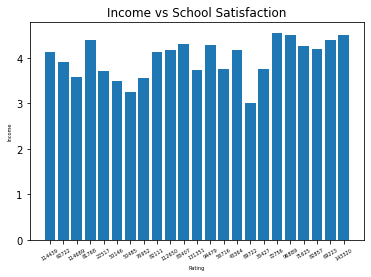

In [33]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(income))
    plt.bar(index, rating)
    plt.xlabel('Rating', fontsize=5)
    plt.ylabel('Income', fontsize=5)
    plt.xticks(index, income, fontsize=5, rotation=30)
    plt.title('Income vs School Satisfaction')
    plt.plot()
    plt.savefig(os.getenv('DATA_DIR')+'/processed/rating_income_bar.png')
def plot_line_x():
    # this is for plotting purpose
    index = np.arange(len(income))
    plt.plot(index, rating)
    plt.xlabel('Rating', fontsize=5)
    plt.ylabel('Income', fontsize=5)
    plt.xticks(index, income, fontsize=5, rotation=30)
    plt.title('Income vs School Satisfaction')
    plt.plot()
    plt.savefig(os.getenv('DATA_DIR')+'/processed/rating_income_line.png')
    
plot_bar_x()
#plot_line_x()

Best fit line equation taken almost verbatim from a stack overflow answer, but fit really nicely to the data we are working with, so I cited it as a comment in the code.

Prints out a line to see how our data trends.

As expected, we saw an upward trend of satisfaction in the wealthier zipcodes.

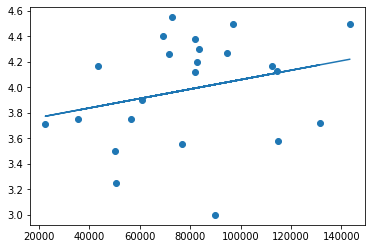

In [34]:
#from https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python

def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return a, b

a, b = best_fit(income, rating)
plt.scatter(income, rating)
yfit = [a + b * xi for xi in income]
plt.plot(income, yfit)
plt.savefig(os.getenv('DATA_DIR')+'/processed/best_fit_line.png')

This is the part of the code that looks at distribution of schools. If there was a noticeable uneven distribution, we would want to look into perhaps why, but there wasn't so we just have a nice graph to look at.

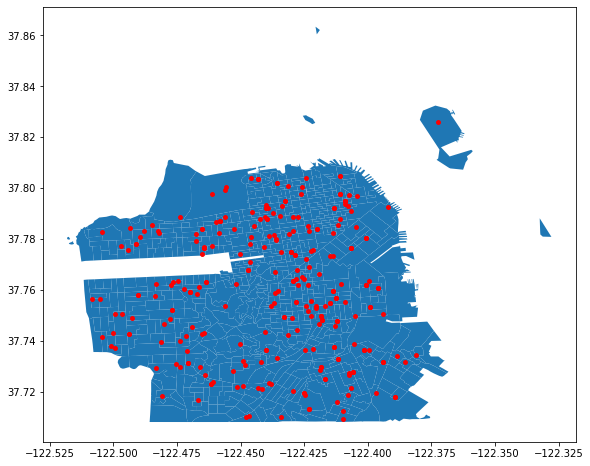

In [35]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

gdf = GeoDataFrame(df, geometry=geometry)

soa_shape_map_path = os.getenv('DATA_DIR')+'/raw/s7q88r.shp'
soa_shape_map = gpd.read_file(soa_shape_map_path)
soa_shape_map_geo = soa_shape_map.to_crs(epsg=4326)

gdf.plot(ax=soa_shape_map_geo.plot(figsize=(100, 8)), marker='o', color='red', markersize=15);
plt.savefig(os.getenv('DATA_DIR')+'/processed/sf_schools.png')

Sample data from our dataframe we crafted

In [36]:
print(df)

      latitude   longitude                      id  \
0    37.783802 -122.420105  LFEBCjZ-M3XUFJDszYFX6A   
1    37.783802 -122.420105  02ydF1Ft56qng9zMWG1lbw   
2    37.766884 -122.436279  hR5UIYYrYEdiQqxE1h6Log   
3    37.754967 -122.437004  BpY47-RBGqOY5uovSd_WoA   
4    37.785046 -122.423416  t5Drl8K8lE6kVTQzhO4RSw   
..         ...         ...                     ...   
285  37.738636 -122.450188  94sAjDIl_rgw07hdELxW6w   
286  37.789124 -122.434509  -agG8Ikc90oLqaufFxT3Sg   
287  37.782593 -122.504578  ClTJMcv7_pWlSyBChhBCzQ   
288  37.775639 -122.494286  SOPtNapoQcOZ_z6R2MyasA   
289  37.775013 -122.433899  sfF3fmFlzhLPNIXSxMyUvw   

                              name  rating zipcode  \
0               Milkbomb Ice Cream     4.5   94107   
1                           Milk +     3.5   94109   
2       McKinley Elementary School     5.0   94114   
3           Eureka Learning Center     4.5   94114   
4     Montessori House of Children     4.5   94109   
..                         